In [137]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import random

from skimage import io, transform

from torch.utils.data import Dataset, DataLoader


[[0.8102172359965896, 0.9021659504395827, 0.3101475693193326], [0.7298317482601286, 0.8988382879679935, 0.6839839319154413], [0.47214271545271336, 0.1007012080683658, 0.4341718354537837]]
(128, 128, 3)


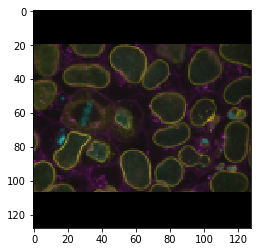

In [151]:
# functions to show an image

def imshow(img):
    plt.imshow(img)
    plt.show()

render_parameters = [random.random() for i in range(9)]
render_parameters = [[random.random() for i in range(3)] for j in range(3)]

print(render_parameters)
image = io.imread("\\\\allen\\aics\\animated-cell\\Allen-Cell-Explorer\\Allen-Cell-Explorer_1.4.0\\Cell-Viewer_Thumbnails\\AICS-13\\AICS-13_1516.png")
print(image.shape)
imshow(image)




(128, 128, 3)


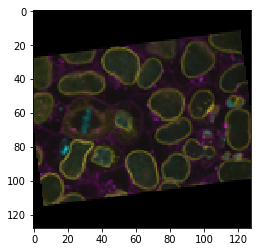

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
torch.Size([1, 3, 128, 128])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ...

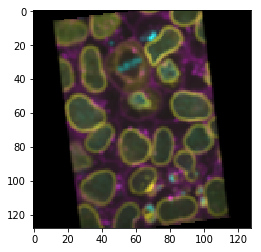

In [174]:
# rotate the image by a random angle, return result in rotated_image
apply_camera = transforms.RandomRotation(45, resample=PIL.Image.BICUBIC)
# print(image.shape)
# rotated_image = apply_camera(Image.fromarray(image))
# imshow(rotated_image)

random.seed(a=0)
convfilter = [[random.random() for i in range(3)] for j in range(3)]
convfilter = [[0,1,0], [1,1,1], [0,1,0]]
# 3 times for r,g,and b
render_parameters = [convfilter]
# print(image)
renderedimage = torch.nn.functional.conv2d(
    torch.Tensor([image.transpose(2,1,0)]), torch.Tensor([render_parameters, render_parameters, render_parameters]),
    bias=None, stride=1, 
    padding=1, dilation=1, 
    groups=3
)
print(renderedimage)
print(renderedimage.shape)
print(renderedimage[0])

maxval = renderedimage.max()
renderedimage = torchvision.transforms.functional.normalize(renderedimage[0], mean=[0,0,0], std=[maxval, maxval, maxval])
renderedimage_pil = torchvision.transforms.functional.to_pil_image(renderedimage, mode=None)

final_image = apply_camera(renderedimage_pil)
print(final_image)
imshow(final_image)


In [175]:
class TestConvDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.all_files = []
        for name in os.listdir(self.root_dir):
            full = os.path.join(self.root_dir, name)
            if os.path.isfile(full) and name[-4:]==".png":
                self.all_files.append(name)
        num_files = len(self.all_files)
        print(num_files)

    def __len__(self):
        return len(self.landmarks_frame)

    # returns a Tensor that is a 2D RGB image
    def render_function(self, input_data, render_params, camera_transform):
        # note that groups=3 and we only put one in the array here
        # this is reshaping to make the conv2d happy
        reshaped_params = [render_params]
        renderedimage = torch.nn.functional.conv2d(
            torch.Tensor([input_data]), torch.Tensor([reshaped_params, reshaped_params, reshaped_params]),
            bias=None, stride=1, 
            padding=1, dilation=1, 
            groups=3
        )
        maxval = renderedimage.max()

        renderedimage = torchvision.transforms.functional.normalize(renderedimage[0], mean=[0,0,0], std=[maxval, maxval, maxval])
        renderedimage_pil = torchvision.transforms.functional.to_pil_image(renderedimage, mode=None)

        final_image = camera_transform(renderedimage_pil)
        return final_image
        
    
    def __getitem__(self, idx):
        # load some input_data for our render_function
        img_name = os.path.join(self.root_dir, self.all_files[idx])
        image = io.imread(img_name)
        
        # generate a repeatable set of render parameters for our render_function
        random.seed(a=idx)
        convfilter = [[random.random() for i in range(3)] for j in range(3)]

        camera_samples = 10
        camera_degree_range = 45.0
        apply_camera = transforms.RandomRotation(camera_degree_range, resample=PIL.Image.BICUBIC)

        # loop
        images = []
        im_2d_cube_ids = []
        for i in range(camera_samples):
            renderedimage = self.render_function(image.transpose(2,1,0), convfilter, apply_camera)
            images.append(renderedimage)
            im_2d_cube_ids.append(idx)

        sample = {'im_cube': image, 'im_2d': images, 'im_2d_cube_id': im_2d_cube_ids, 'render_parameters': convfilter}

        
        if self.transform:
            sample = self.transform(sample)

        return sample



8


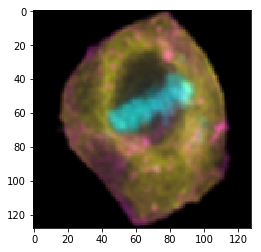

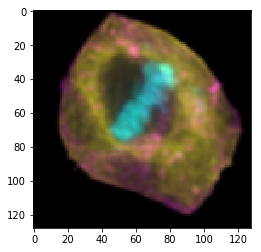

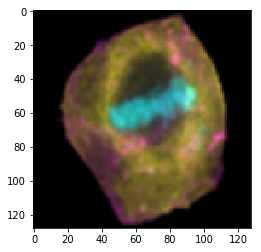

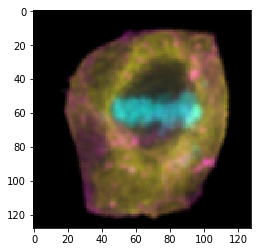

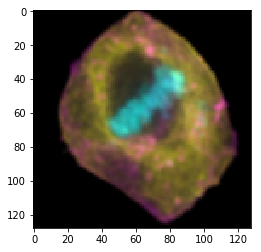

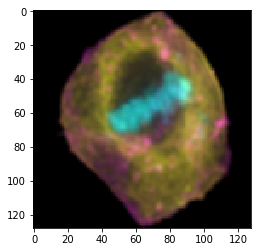

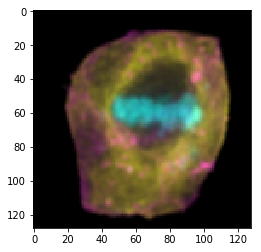

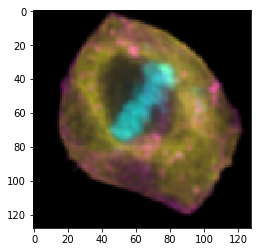

In [179]:
testDataset = TestConvDataset(root_dir = "\\\\allen\\aics\\animated-cell\\Dan\\test\\fake_dataset")
# testDataset = TestConvDataset(root_dir = "\\\\allen\\aics\\animated-cell\\Dan\\test\\fake_dataset")
item = testDataset.__getitem__(0)
# print(item)
imshow(item["im_2d"][0])
imshow(item["im_2d"][1])
imshow(item["im_2d"][2])
imshow(item["im_2d"][3])
imshow(item["im_2d"][4])
imshow(item["im_2d"][5])
imshow(item["im_2d"][6])
imshow(item["im_2d"][7])


In [122]:
#Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

# transforms an image to a Tensor, with a normalization operation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train (bool, optional) If True, creates dataset from training.pt, otherwise from test.pt.
# gets the data and creates a set from training.pt
# both training and testing will be downloaded
# transform takes in a PIL image and returns a transformed version
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# takes the trainset we defined, loads 4 (default 1) at a time, 
# shuffle=True reshuffles the data every epoch
# for shuffle, an epoch is defined as one full iteration through the DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# gets the data from test.pt, transforms it
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# same as trainloader 
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# order of the classes in the set, the data set stores labels as indices
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# get some random training images
dataiter = iter(trainloader)


In [5]:
# torch.nn.Module is the base class for all neural network modules
# Your models should also subclass this class.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #  nn.Conv2d: Applies a 2D convolution over an input signal composed of several input planes.
        # args: in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'
        # This results in 2 "parameters": 6 learned kernels of size 5x5 per input channel (3) plus 6 learned scalar bias terms
        self.conv1 = nn.Conv2d(3, 6, 5) 
        # Applies a 2D max pooling over an input signal composed of several input planes.
        # args: (kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        # This results in 2x2 downsampling with a "max" filter
        self.pool = nn.MaxPool2d(2, 2)
        # This results in 2 "parameters": 16 learned kernels of size 5x5 per input channel (6) plus 16 learned scalar bias terms
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Applies a linear transformation to the incoming data: y = xA^T + b
        # args: (in_features, out_features, bias=True)
        # This results in 2 "parameters": 120 learned linear weight vectors of length 16*5*5, plus 120 learned scalar bias terms
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # This results in 2 "parameters": 84 learned linear weight vectors of length 120, plus 84 learned scalar bias terms
        self.fc2 = nn.Linear(120, 84)
        # This results in 2 "parameters": 10 learned linear weight vectors of length 84, plus 10 learned scalar bias terms
        self.fc3 = nn.Linear(84, 10)

    # running data through the network
    def forward(self, x):
        # relu seems to basically clip the min at 0
        x = self.pool(F.relu(self.conv1(x)))
        # relu seems to basically clip the min at 0
        x = self.pool(F.relu(self.conv2(x)))
        # reshape tensor x to have its second dimension be of size 16*5*5,
        # (to fit into the fc1 ?) 
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [6]:
# this combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Implements stochastic gradient descent (optionally with momentum).
# lr is the learning rate, required
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [7]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    # trainloader is the method that gets 4 examples out of the training dataset at a time
    # each epoch trainloader will shuffle the data because we told it to
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # run batch forward
        outputs = net(inputs)
        # calculate loss function
        loss = criterion(outputs, labels)
        # calculate (accumulate) gradients for whole network
        loss.backward()
        # perform parameter updates based on current gradients
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.204
[1,  4000] loss: 1.876
[1,  6000] loss: 1.697
[1,  8000] loss: 1.587
[1, 10000] loss: 1.499
[1, 12000] loss: 1.479
Finished Training


In [ ]:
dataiter = iter(testloader)
# grab batch of four images again but from data it hasn't seen before
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# calc outputs with our trained network
# outputs are batch size (4) by 10 (number of classes)
# each number is the confidence that the current image is in that class 
# higher number means more confident
outputs = net(images)
# print(outputs)
# outputs are tensors, but we want the one it thinks is most likely 
# torch.max returns (max_value, index)
# therefore "predicted" will hold the index of the max value so we can get the name of the class from the classes array
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
# calc percentage calc labels match the real labels in the testing set
with torch.no_grad():  # just in prediction mode, not learning mode
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)
